# LDA analysis

In [1]:
# TODO: POS, NER, BI/TRI-GRAMS ???

In [2]:
# Import libraries
import pandas as pd
import csv, html, re
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Load data
data = pd.read_csv("drive/MyDrive/data_train_class_balanced_9-4.csv").drop('Unnamed: 0', axis = 1)
data['review'] = data['review'].apply(html.unescape)

In [5]:
# View data head
data.head()

,drugName,condition,review,rating,date,positiveness,drugClass
0,trazodone,Insomnia,"""I have insomnia, it's horrible. My story begi...",10.0,"April 3, 2016",1,antidepressants
1,fluvoxamine,Anxiety and Stress,"""I've suffered from panic attacks and anxiety ...",9.0,"January 3, 2011",1,antidepressants
2,mirtazapine,Anxiety,"""Suffered from anxiety and depression for 3 mo...",10.0,"May 31, 2012",1,antidepressants
3,trazodone,Depression,"""I take trazodone to help balance the effects ...",10.0,"June 1, 2016",1,antidepressants
4,mirtazapine,Anxiety,"""I have taken this medicine for 7 years. Gaine...",10.0,"November 6, 2012",1,antidepressants


In [6]:
data.shape

(36094, 7)

## Preprocessing

In [7]:
# Import Text Mining libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from textblob import TextBlob
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [8]:
# Define useful classes
%%capture
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
def correct (text):
  textBlb = TextBlob(text)        
  textCorrected = textBlb.correct()
  return textCorrected

In [10]:
def preprocessing(text):

  # Tokenization
  tokens = word_tokenize(text.lower())

  # Keep only alphabet strings
  tokens = [t for t in tokens if t.isalpha()]

  # Correct text
  # tokens = [correct(t) for t in tokens]

  # Stop words removal
  tokens = [t for t in tokens if t not in stop_words]

  # Lemmatization
  # tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]

  # Stemming (Porter stemmer)
  tokens = [porter_stemmer.stem(t) for t in tokens]

  # Short words removal
  # tokens = [t for t in tokens if len(t) > 2]

  return tokens

In [11]:
# Preprocess data
reviews = data['review'].apply(preprocessing)

In [12]:
# Create dictionary
dictionary = gensim.corpora.Dictionary(reviews)

# Filter words that occurs in less than 'less'% documents and words that occurs in more than 'more'% of total documents. Keep top 'keep_n' frequent words
less = 5 # to be fixed according to STM
more = 55 # to be fixed
keep_n = 100000
dictionary.filter_extremes(no_below = less/100, no_above = more/100, keep_n = keep_n)

# Create BoW
bow_corpus = [dictionary.doc2bow(doc) for doc in reviews]

## LDA

In [13]:
# Get best LDA according to highest coherence based on number of topics
def get_topic_coherence(topic_num: list):
  coherence = []
  for num_topics in topic_num:
    lda_model = gensim.models.LdaModel(corpus = bow_corpus,
                                        id2word = dictionary,
                                        num_topics = num_topics,
                                        offset = 2,
                                        random_state = 123,
                                        update_every = 1,
                                        passes = 10,
                                        alpha = 'auto',
                                        eta = "auto",
                                        per_word_topics = True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
    coherence = coherence + [coherence_model_lda.get_coherence()]
  return coherence

In [17]:
topic_num = [3, 4, 5, 6, 7, 8]
coherence = get_topic_coherence(topic_num = topic_num)

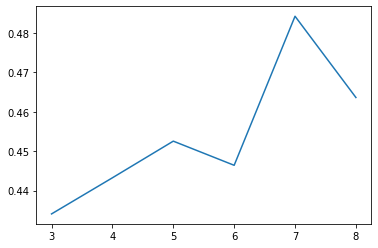

In [18]:
plt.plot(topic_num, coherence)

In [19]:
opt_num = 7
lda_model = gensim.models.LdaModel(corpus = bow_corpus,
                                        id2word = dictionary,
                                        num_topics = opt_num,
                                        offset = 2,
                                        random_state = 123,
                                        update_every = 1,
                                        passes = 10,
                                        alpha = 'auto',
                                        eta = "auto",
                                        per_word_topics = True)

In [20]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.034*"effect" + 0.032*"side" + 0.031*"feel" + 0.021*"day" + 0.021*"week" + '
  '0.017*"take" + 0.016*"start" + 0.016*"like" + 0.012*"first" + 0.011*"get"'),
 (1,
  '0.029*"took" + 0.027*"day" + 0.018*"hour" + 0.018*"pill" + 0.016*"take" + '
  '0.015*"work" + 0.013*"time" + 0.012*"go" + 0.010*"start" + 0.010*"water"'),
 (2,
  '0.031*"cramp" + 0.028*"period" + 0.022*"pain" + 0.020*"get" + 0.019*"month" '
  '+ 0.019*"day" + 0.019*"bleed" + 0.016*"got" + 0.012*"week" + '
  '0.012*"insert"'),
 (3,
  '0.018*"patch" + 0.018*"inject" + 0.017*"use" + 0.011*"drug" + 0.010*"insur" '
  '+ 0.009*"effect" + 0.008*"one" + 0.008*"tri" + 0.007*"cover" + '
  '0.007*"doctor"'),
 (4,
  '0.044*"weight" + 0.033*"month" + 0.028*"gain" + 0.018*"year" + 0.018*"pill" '
  '+ 0.015*"control" + 0.015*"pound" + 0.014*"start" + 0.013*"lost" + '
  '0.012*"lb"'),
 (5,
  '0.017*"year" + 0.017*"take" + 0.016*"anxieti" + 0.015*"life" + '
  '0.014*"medic" + 0.011*"work" + 0.011*"drug" + 0.011*"feel" + '
  '0.011*

In [21]:
# Compute Perplexity (lower is better)
print('Perplexity: ', lda_model.log_perplexity(bow_corpus))  

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -6.841213835996103

Coherence Score:  0.48422873078162026


In [22]:
%%capture
!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.002651  0.070626       1        1  21.999783
0      0.073855  0.017734       2        1  16.837695
2      0.077168 -0.121573       3        1  15.835921
6     -0.003445  0.164314       4        1  15.708188
4      0.096677 -0.157960       5        1  13.944431
1      0.057433  0.090129       6        1  10.709980
3     -0.299038 -0.063269       7        1   4.964002, topic_info=         Term          Freq         Total Category  logprob  loglift
87     weight   8889.000000   8889.000000  Default  30.0000  30.0000
318      pain  12686.000000  12686.000000  Default  29.0000  29.0000
1766    cramp   7244.000000   7244.000000  Default  28.0000  28.0000
958   migrain   7192.000000   7192.000000  Default  27.0000  27.0000
59       gain   5769.000000   5769.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
333     howev    306.945723   2252.508067   Topic7  -5.4650   1.0098
117      side    345.593209  10482.368941   Topic7  -5.3465  -0.4092
134       bad    327.214001   6736.857942   Topic7  -5.4011  -0.0218
151     would    329.669786   9459.986795   Topic7  -5.3936  -0.3538
218     thing    304.104384   4882.741618   Topic7  -5.4743   0.2269

[513 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1287       1  0.999996       abilifi
3620       6  0.998651         abort
3490       6  0.998278          achi
4447       5  0.999820           acn
539        1  0.104972        actual
...      ...       ...           ...
89         7  0.005120          year
14500      5  1.000999  zolmitriptan
255        1  0.998896        zoloft
3641       4  0.999761         zomig
4043       5  0.999874       zyprexa

[1082 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 7, 5, 2, 4])

In [24]:
# Find stemmed words
word = "tri\w+"
sorted(dict(zip(*np.unique([itm[0] for itm in data['review'].str.findall(r'{}'.format(word)) if len(itm)>0], return_counts = True))).items(), key= lambda x: x[1], reverse = True)[:5]

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-24-f8ffdcd9292b>:2: DeprecationWarning: invalid escape sequence \w
  word = "tri\w+"


[('tried', 3042),
 ('trin', 789),
 ('trist', 354),
 ('trial', 162),
 ('trings', 154)]